# Quality inspection of manufactured product

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/quality_check.gif)

Deep learning can be used to automate the inspection process of manufactured goods.

It is crucial to identify defective products to maintian the reputation of the product in the market as well as for safety concerns in some cases. Deep learning help identify the defective ones with high accuracy.

The output of the model can be used to triiger a movement to seperate the defective product from the non defective ones.

---

The notebook differentiates between defective and non-defective casting products.

Casting defect is an undesired irregularity in a metal casting process.

There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.


In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random
from sklearn.metrics import confusion_matrix

## Downloading the dataset

Source of dataset - [kaggle](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

In [2]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/casting_data.zip"
!unzip -q casting_data.zip

--2020-10-15 05:23:09--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/casting_data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.32
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71990076 (69M) [application/zip]
Saving to: ‘casting_data.zip’

casting_data.zip    100%[===================>]  68.65M  92.1MB/s    in 0.7s    

2020-10-15 05:23:10 (92.1 MB/s) - ‘casting_data.zip’ saved [71990076/71990076]



The dataset has two folders - train and test, each with subfolders - def_front (defective) and ok_front (non-defective).

In [3]:
dataset_path = 'casting_data'
batch = 32

# The train and test datasets
print("Train dataset")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path+'/train', batch_size=batch)

print("Test dataset")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path+'/test', batch_size=batch)

Train dataset
Found 6377 files belonging to 2 classes.
Test dataset
Found 715 files belonging to 2 classes.


#### Understanding the subfolders

In [4]:
class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)

Train class names:  ['def_front', 'ok_front']
Test class names:  ['def_front', 'ok_front']


## Visualizing the samples in the dataset

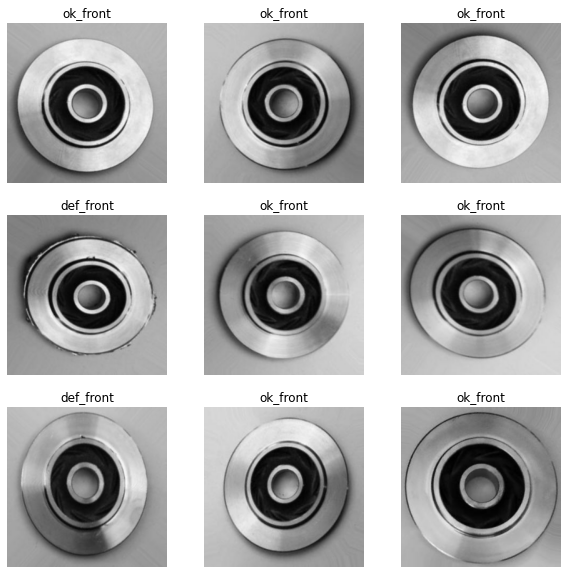

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

In [6]:
print("Looking into the shape of images and labels in one batch\n")  

for image_batch, labels_batch in train_ds:
    print("Shape of images input for one batch: ", image_batch.shape)
    print("Shape of images labels for one batch: ", labels_batch.shape)
    break

Looking into the shape of images and labels in one batch

Shape of images input for one batch:  (32, 256, 256, 3)
Shape of images labels for one batch:  (32,)


In [7]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Model 

In [8]:
model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPool2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPool2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPool2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation = 'softmax')
])

model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
history = model.fit(train_ds, epochs=8)

Epoch 1/8
200/200 [==============================] - 209s 1s/step - loss: 0.5492 - accuracy: 0.7242
Epoch 2/8
200/200 [==============================] - 207s 1s/step - loss: 0.2692 - accuracy: 0.8840
Epoch 3/8
200/200 [==============================] - 207s 1s/step - loss: 0.1138 - accuracy: 0.9638
Epoch 4/8
200/200 [==============================] - 207s 1s/step - loss: 0.0652 - accuracy: 0.9804
Epoch 5/8
200/200 [==============================] - 213s 1s/step - loss: 0.0526 - accuracy: 0.9840
Epoch 6/8
200/200 [==============================] - 209s 1s/step - loss: 0.0378 - accuracy: 0.9881
Epoch 7/8
200/200 [==============================] - 208s 1s/step - loss: 0.0244 - accuracy: 0.9934
Epoch 8/8
200/200 [==============================] - 211s 1s/step - loss: 0.0139 - accuracy: 0.9964


In [10]:
model.evaluate(test_ds)

23/23 [==============================] - 7s 286ms/step - loss: 0.0180 - accuracy: 0.9958


[0.017969854176044464, 0.9958041906356812]

#### Plotting the metrics

In [11]:
def plot(history, variable):
    plt.plot(range(len(history[variable])), history[variable])
    plt.title(variable)

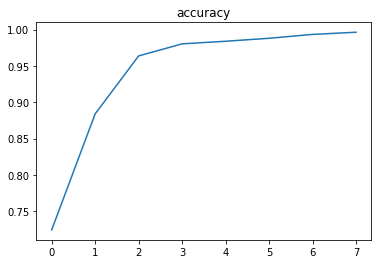

In [12]:
plot(history.history, "accuracy")

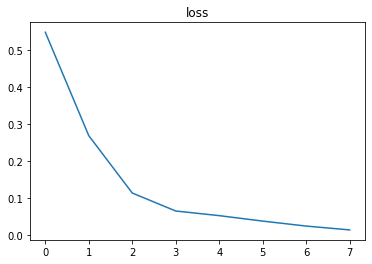

In [13]:
plot(history.history, "loss")

## Prediction

Prdicted:  def_front
True:  def_front
Probability:  0.99999225


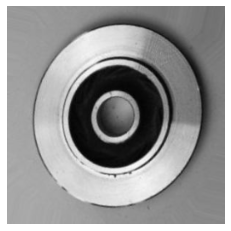

In [14]:
# pick random test data sample from one batch
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (32, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

## deepC

In [15]:
model.save('quality_check.h5')

In [16]:
!deepCC quality_check.h5

reading [keras model] from 'quality_check.h5'
Saved 'quality_check.onnx'
reading onnx model from file  quality_check.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) conv2d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_1's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_1) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  quality_check_deepC/quality_check.cpp
INFO (ONNX): model files are ready in dir quality_check_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 quality_check_deepC/quality_check.cpp -o quality_check_deepC/quality_check.exe
Model executable  quality_check_deepC/quality_check.exe


True:  ok_front
reading file sample.data.
Warn: conv2d_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_1_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_2_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
writing file dense_1.out.
Model predicted the product quality:  ok_front  with prbability  0.783748


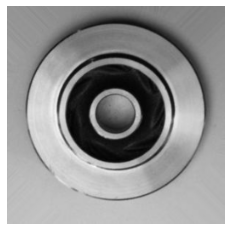

In [17]:
# pick random test data sample from the batch
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():    
    img, label = i      # i contains all test samples
    np.savetxt('sample.data', (img[x]).flatten())    # xth sample into text file
    plt.axis('off')
    plt.imshow(img[x])
    print("True: ", class_names[label[x]])
    break

# run exe with input
!quality_check_deepC/quality_check.exe sample.data

# show predicted output
nn_out = np.loadtxt('dense_1.out')
pred = np.argmax(nn_out)
print ("Model predicted the product quality: ", class_names[pred], " with prbability ", nn_out[pred])
